<a href="https://colab.research.google.com/github/davetew/Zero-Carbon-Aviation/blob/master/Zero_Carbon_Aircraft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zero-Carbon Aircraft Propulsion and Energy Storage System Options
This notebook contains an assessment of the viability of several zero-carbon commerical aircraft combined energy storage and propulsion system options.

## Energy Storage
The energy storage options to be considered include--
1.   Batteries \\
    a.  [Lithium Ion](https://en.wikipedia.org/wiki/Lithium-ion_battery) \\
    b.  [Lithium Air](https://en.wikipedia.org/wiki/Lithium–air_battery)
    
2.   Fuels \\
    a.  Bio-Kerosene \\
    b.  Ammonia \\
    c.  Hydrogen
    
3.  Nuclear \\
    a.  Thorium-232 \\
    b.  TBD

## Propulsion System
In this context, the propulsion system consists of the chemical/nuclear to shaft power energy conversion system and the propulsor that converts the shaft power into aircraft thrust.

The chemical/nuclear to shaft power propulsion system options that will be considered include--
1.  Open Brayton cycle gas turbines,
2.  Closed Brayton cycles (e.g. $sCO_{2}$ cycles),
3.  Fuel cells with electric motors,
4.  Batteries with electric motors, and
5.  Hybrid cycles using the above technologies that leverage both fuel and battery energy storage systems.

The propulsor options that will be considered include--
1.  Ducted fans, and
2.  Unducted fans.


In [0]:
"""Import the standard modules"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
from io import BytesIO

from IPython.display import Markdown

In [0]:
"""Install, import, and configure 'pint' -- a physical quantity manipulation package"""
!pip install pint
import pint

# Save default unit registry in ureg & Quantity in Q_
ureg = pint.UnitRegistry()
Q_ = ureg.Quantity

# Define a currency dimension with usd (US dollar) as the base unit
ureg.define('usd = [currency]')

In [0]:
# Install Cantera & import module
!apt-add-repository -y ppa:speth/cantera
!apt-get install cantera-python3

import cantera as ct

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/speth/cantera/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done
Reading package lists... Done
Bui

In [0]:
"""Define fuel property classes"""

class Fuel:
    """Fuel specification class"""
    def __init__(self, phase_definition=None, 
                 specific_cost=None,
                 liquid_density=None):
      
        self.phase_definition = phase_definition
        self.phase = ct.Solution(source=phase_definition)
        self.specific_cost = specific_cost
        self.liquid_density = liquid_density
    
    @property
    def cost_liquid_volume_specific(self, unit_string='usd/liter'):
      """Calculate and return the liquid volume specific cost"""
      if self.specific_cost.to_base_units().units == ureg['usd/meters**3']:
        
        # Input specfic cost is already liquid volume specific - convert to specified units
        return self.specific_cost.to(ureg[unit_string])
      
      elif self.specific_cost.to_base_units().units == ureg['usd/kg']:
        
        # Input specific cost is mass-specific - calculate & return volumetric cost
        return (self.specific_cost * self.liquid_density).to(ureg[unit_string])
 
    @property
    def cost_mass_specific(self, unit_string='usd/kg'):
      """Calculate and return the mass specific cost"""
      if self.specific_cost.to_base_units().units == ureg['usd/kg']:
        
        # Input specfic cost is already mass specific - convert to specified units
        return self.specific_cost.to(ureg[unit_string])
      
      elif self.specific_cost.to_base_units().units == ureg['usd/meters**3']:
        
        # Input specific cost is volume-specific - calculate & return mass-specific cost
        return (self.specific_cost / self.liquid_density).to(ureg[unit_string])
        
    @property
    def lower_heating_value(self):
      """Calculate and return the lower heating value"""
      
      # Specify the reactant state
      reactants = ct.Solution(source=self.phase_definition)
      reactants.TP = 298, ct.one_atm
      reactants.set_equivalence_ratio(1.0, self.phase.name, 'O2:1.0')
      
      # Calculate the fuel mass fraction
      Y_fuel = reactants[self.phase.name].Y[0]
      
      # Complete combustion products
      Y_products = {'CO2': reactants.elemental_mole_fraction('C'),
                    'H2O': 0.5 * reactants.elemental_mole_fraction('H'),
                    'N2': 0.5 * reactants.elemental_mole_fraction('N')}
      
      # Calculate the product enthalpy at 298 K, 1 atm
      products = ct.Solution(source=self.phase_definition)
      products.TPX = 298, ct.one_atm, Y_products
      
      return Q_( (reactants.enthalpy_mass - products.enthalpy_mass) / Y_fuel,
                ureg['J/kg'] )
    
    @property
    def cost_energy_specific(self, unit_string='usd/kWh'):
        """Calculate the energy-specific cost of fuel on a lower-heating-value basis."""
        return (self.cost_mass_specific / self.lower_heating_value).to(ureg[unit_string])

      
class Methane(Fuel):
    """Methane per the NASA CEA Code Specification"""
    def __init__(self, specific_cost=Q_(1.4, ureg['usd/liter'])):
      
      # Initialize the superclass using the below Cantera phase definition
      Fuel.__init__(self, phase_definition=
                    '''ideal_gas(name='CH4',
                        elements='C O H N',
                        species='nasa_gas:CH4 H2O CO2 O2 N2',
                        options=['skip_undeclared_elements'],
                        initial_state=state(temperature=300, pressure=101325))''', 
                    specific_cost=specific_cost,
                    liquid_density=Q_(423, ureg['kg/meter**3']))
      
class JetA(Fuel):
    """Jet Fuel per the NASA CEA Code Specification"""
    def __init__(self, specific_cost=Q_(1.4, ureg['usd/liter'])):
      
      # Initialize the superclass using the below Cantera phase definition
      Fuel.__init__(self, phase_definition=
                    '''ideal_gas(name='Jet-A(g)',
                        elements='C O H N',
                        species='nasa_gas:Jet-A(g) H2O CO2 O2 N2',
                        options=['skip_undeclared_elements'],
                        initial_state=state(temperature=300, pressure=101325))''', 
                    specific_cost=specific_cost,
                    liquid_density=Q_(804, ureg['kg/meter**3']))

class Ammonia(Fuel):
    """Ammonia per the NASA CEA Code Specification"""
    def __init__(self, specific_cost=Q_(500, ureg['usd/tonne'])):
      
      # Initialize the superclass using the below Cantera phase definition
      Fuel.__init__(self, phase_definition=
                    '''ideal_gas(name='NH3',
                        elements='C O H N',
                        species='nasa_gas:NH3 H2O CO2 O2 N2',
                        options=['skip_undeclared_elements'],
                        initial_state=state(temperature=300, pressure=101325))''', 
                    specific_cost=specific_cost,
                    liquid_density=Q_(682, ureg['kg/meter**3']))    

class Hydrogen(Fuel):
    """Ammonia per the NASA CEA Code Specification"""
    def __init__(self, specific_cost=Q_(4, ureg['usd/kg'])):
      
      # Initialize the superclass using the below Cantera phase definition
      Fuel.__init__(self, phase_definition=
                    '''ideal_gas(name='H2',
                        elements='C O H N',
                        species='nasa_gas:H2 H2O CO2 O2 N2',
                        options=['skip_undeclared_elements'],
                        initial_state=state(temperature=300, pressure=101325))''', 
                    specific_cost=specific_cost,
                    liquid_density=Q_(71, ureg['kg/meter**3'])) 

Methane:
LHV = 50.02623338058086 megajoule / kilogram
Cost = 0.23817291072820182 usd / kilowatt_hour

Jet A
LHV = 43.35160693795657 megajoule / kilogram
Cost = 0.1446003310878282 usd / kilowatt_hour

Ammonia
LHV = 18.601752772994566 megajoule / kilogram
Cost = 0.09676507488117908 usd / kilowatt_hour

Hydrogen
LHV = 119.95908287214176 megajoule / kilogram
Cost = 0.12004093108437833 usd / kilowatt_hour



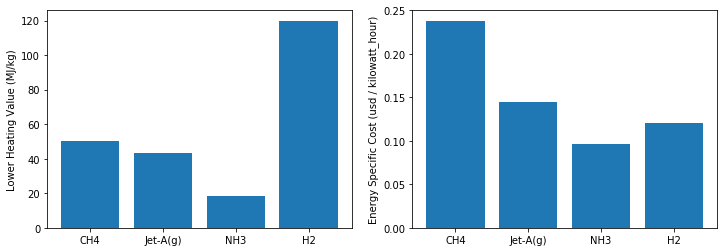

In [0]:
ch4 = Methane()
print('Methane:')
print(f'LHV = {ch4.lower_heating_value.to(ureg.MJ/ureg.kg)}')
print(f'Cost = {ch4.cost_energy_specific}')
print()

bioK = JetA()
print('Jet A')
print(f'LHV = {bioK.lower_heating_value.to(ureg.MJ/ureg.kg)}')
print(f'Cost = {bioK.cost_energy_specific}')
print()

nh3 = Ammonia()
print('Ammonia')
print(f'LHV = {nh3.lower_heating_value.to(ureg.MJ/ureg.kg)}')
print(f'Cost = {nh3.cost_energy_specific}')
print()

h2 = Hydrogen()
print('Hydrogen')
print(f'LHV = {h2.lower_heating_value.to(ureg.MJ/ureg.kg)}')
print(f'Cost = {h2.cost_energy_specific}')
print()

fuels = [ch4, bioK, nh3, h2]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ind = np.arange(1,len(fuels)+1)

ax1.bar(ind, [fuel.lower_heating_value.to('MJ/kg').magnitude for fuel in fuels])
ax1.set_xticks(ind)
ax1.set_xticklabels([fuel.phase.name for fuel in fuels])
ax1.set_ylabel('Lower Heating Value (MJ/kg)')

ax2.bar(ind, [fuel.cost_energy_specific.magnitude for fuel in fuels])
ax2.set_xticks(ind)
ax2.set_xticklabels([fuel.phase.name for fuel in fuels])
ax2.set_ylabel(f'Energy Specific Cost ({fuels[0].cost_energy_specific.units})')

plt.show()

## Aircraft Performance Data
Performance data for 'representative' aircraft from four different aircraft classes are stored in the JSON-format-like `AircraftData` dictionary.  These aircraft include the following commercial aircraft--
1.  A turboprop [Bomardier Dash 8-Q400](https://en.wikipedia.org/wiki/Bombardier_Dash_8),
2.  A regional jet [Airbus A220-300](https://www.airbus.com/aircraft/passenger-aircraft/a220-family/a220-300.html),
3.  A single aisle [Boeing 737 MAX 8](https://en.wikipedia.org/wiki/Boeing_737_MAX), and
4.  A twin aisle [Boeing 777X](https://en.wikipedia.org/wiki/Boeing_777X).

The data provided include the following types of information--
1. Weight,
2. Wing geometry,
3. Cruise speed and/or Mach number,
3. Payload (fuel & passengers),
4. Cost,
5. Engines.

More detailed information on these characteristics is provided below.

### Weight
When available, four different weights are recorded within the dictionary.  These weight include--
1. Maximum Gross Take-Off Weight ($MTOW$),
2. Maximum Zero Fuel Weight ($MZFW$),
3. Operating Empty Weight ($OEW$), and
4. Maximum Landing Weight ($MLW$),

$MTOW$ is the maximum authorized weight at brake release.  $TOW$ is the actual take-off weight, which may be calculated from the below expression.

$$TOW = OEW + PL + FW$$

$$TOW \leq MTOW$$

$PL$ is the payload weight, and $FW$ is the fuel weight.  $OEW$ is the operating empty weight of the aircraft; it includes the weight of the aircraft structure ($SW$) and the weight of the propulsion system ($PW$)--

$$OEW = SW + PW$$

$MZFW$ is the maximum aircraft weight before fuel and other consumable propulsion system agents are loaded onto the aircraft.

$$MZFW = OEW + PL_{max}$$

$PL_{max}$ is the maximum payload.

In this context, the payload weight ($PL$) includes passengers, luggage, cargo, crew, food, beverages and related supplies.  Also, the fuel weight ($FW$) is assumed to include all propulsion-related consumables (e.g. fuel, oil).

For purposes of the propulsion and energy storage system analyses anticipated in this notebook, the aircraft considered will be assumed to take-off at their maximum take-off weight ($MTOW$) with their maximum payloads ($PL_{max}$). 

\begin{align}
MTOW & = OEW + PL_{max} + FW \\
& = SW + PW + PL_{max} + FW \\
& = SW + PL_{max} + PW + FW
\end{align}

The maximum payload is calculated from the available $MZFW$ and $OEW$ data--

$$PL_{max} = MZFW - OEW$$

Also, the fuel weight will be calculated from the available $MTOW$ and $OEW$ and the calculated $PL_{max}$.

$$FW = MTOW - OEW - PL_{max}$$

The propulsion system weight ($PW$) will be estimated from the engine data contained within the dictionary.  However, this weight is likely an underestimate of the weight as it is likely not inclusive of the engine nacelle and pylon.








In [0]:
"""Load aircraft data"""

# Get data from Google spread sheet on Dave's G Drive
rawACData = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vSA_H7NEvMSQTltN4FRqKaJ-8uWw_bDHwP2WarH4PzRh8Qm3IOajMyOMxhZ1hzv9Ui-tXKjMt9KhvuY/pub?gid=0&single=true&output=csv')

# Save the data in a pandas data frame
AircraftData = pd.read_csv(BytesIO(rawACData.content), index_col=0)

# Use the unit designation in the index to create pint physical quantities for the numerical data

def get_index_units(dataframe):
  
  unit_strings = []
  for index, row in AircraftData.iterrows():
    
  
  # Create unit string from text between parentheses
  unit_sting = index
display(AircraftData)



,Dash-8-Q400,A220-300,737 MAX 8,777-9X
Aircraft,,,,
Max Take Off Weight (kg),"29,260","67,600","82,191","351,500"
Max Landing Weight (kg),"28,010","58,700","69,309","266,000"
Max Zero Fuel Weight (kg),"25,850","55,800","65,952","255,000"
Operating Empty Weight (kg),"17,110","37,081","45,070","181,400"
Cruise Mach,None,0.82,0.79,None
Cruise Speed (km/hr),667,829,839,900
Wing Area (m**2),63.1,112.3,127,466.8
Wing Span (m),28.4,35.1,35.92,71.8
Fuel Capacity (L),"6,530","21,918","25,817","198,000"


In [0]:
"""Load Engine Data"""
rawEngData = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vQ5-u7udgzqZoPJy4Ao6RTlmFTSbg3_71hMCk9AkI_x1yTCiGVxs4ltPtdKUrMduxsepPMq6e0QzaCz/pub?gid=0&single=true&output=csv')
EngineData = pd.read_csv(BytesIO(rawEngData.content), index_col=0)
display(EngineData)

,PW150A,PW1500G,CFM LEAP 1B,GE9X-105B1A
Name,,,,
Type,Turboprop,Turbofan,Turbofan,Turbofan
OPR,None,None,40,61
BPR,None,12,9,10
TSFC (g/kN/s),None,None,12,None
Fan Diameter (m),None,1.85,1.76,3.39
Weight (kg),None,"2,177","2,780","18,182"
Cost (Musd),None,$12.0,$14.5,None
Thrust Take Off (kN),None,108.54,130.41,470
Thrust Max Continuous (kN),None,None,127.62,None


## Propulsion System Performance
The thrust specific fuel consumption (TSFC) of a thrust producing aircraft engine is given by

$$ TSFC = \frac{\dot{m}_{fuel}}{T} $$

$\dot{m}_{fuel}$ is the mass flow rate of fuel, and $T$ is the engine thrust.  Typical metric units for $TSFC$ are $g / kN s$.

The specific impulse of that same engine is given by

$$ I_{sp} = \frac{T}{\dot{m}_{fuel} g}  = \frac{1}{TSFC*g} $$

$g$ is the gravitional acceleration (e.g. $9.8  m/s^2$). The $I_{sp}$ is typically expressed in units of seconds.

For the above-specified units for $TSFC$, $I_{sp}$ in seconds may be calculated from the $TSFC$ per the below expression

$$ I_{sp} = \frac{1e6}{TSFC*g} $$

## Aircraft Range Model 
The range of an aircraft may be estimated from the Breguet range equation, which is derived below for both aircraft that burn fuel and those that take on oxygen (e.g. metal-air battery). 

### Fuel-Consuming Aircraft
The rate of change of mass of a fuel-consuming aircraft during flight is given by

$$ -\frac{dW}{dt} = g\dot{m}_{f} = \frac{T}{I_{sp}}. $$

In steady level flight,

\begin{align}
L & = W \\
T & = D
\end{align}

Hence, the required aircraft thrust may be expressed as a function of the weight and the aircraft lift to drag ratio.

$$ W = L = D\frac{L}{D} = T\frac{L}{D} $$

This expression may be inserted into the above differential equation for rate of change of aircraft mass during flight.

$$ \frac{dW}{dt} = -\frac{W}{(L/D)I_{sp}} $$ 

$$ \frac{dW}{W} = -\frac{dt}{(L/D)I_{sp}} $$

Both sides of the above expression may be integrated to yield and expression that relates the aircraft weight and flight duration.

$$ \ln\frac{W}{W_0} = - \frac{t}{(L/D)I_{sp}} $$

$$ t_{f} = \frac{L}{D}I_{sp}\ln\frac{W_0}{W_f} $$

Knowing the cruise/flight velocity ($V$), the range ($R$) may be calculated.

$$ R = t_{f}V = V \frac{L}{D}I_{sp}\ln\frac{W_0}{W_f} $$

$$ W_{f} = W_{0} - W_{fuel} $$

$$ R_{fc} = t_{f}V = V \frac{L}{D}I_{sp}\ln\frac{W_0}{W_{0} - W_{fuel}} $$

Reference: [MIT Unified Notes](http://web.mit.edu/16.unified/www/FALL/thermodynamics/notes/node98.html)

### Oxygen-Accumulating Aircraft
The rate of change of mass of an oxygen-accumulating aircraft during flight is given by 

$$ \frac{dW}{dt} = g\dot{m}_{O_{2}} = \frac{T}{I'_{sp}}. $$

$$ I'_{sp} = \frac{T}{\dot{m}_{O_{2}}} $$

In steady level flight,

$$ \frac{dW}{W} = \frac{dt}{(L/D)I'_{sp}} $$

Integrating both sides,

$$ \ln\frac{W}{W_0} = \frac{t}{(L/D)I'_{sp}} $$

$$ t_{f} = \frac{L}{D}I'_{sp}\ln\frac{W_f}{W_0} $$

$$ W_{f} = W_{0} + W_{oxygen} $$

$$ R_{oa} = t_{f}V = V \frac{L}{D}I'_{sp}\ln\frac{W_{0} + W_{oxygen}}{W_{0}} $$

### Fuel-consuming & Oxygen-accumulating Aircraft Comparison
For identical aircraft range performance ($R_{fc} = R_{oa}$) and assuming identical airfame performance (i.e. constant $L/D$ & $V$),

$$ I_{sp}\ln\frac{W_0}{W_{0} - W_{fuel}} = I'_{sp}\ln\frac{W_{0} + W_{oxygen}}{W_{0}} $$

$$ \frac{\dot{m}_{O_{2}}}{\dot{m}_{f}}= \frac{\ln\frac{W_{0} + W_{oxygen}}{W_{0}}}{\ln\frac{W_0}{W_{0} - W_{fuel}}} $$

In the overly simplistic scenario, where the total accumulated oxygen can have the same mass as the total consumed fuel,

$$ W_{oxygen} = W_{fuel} = W_{consumables} $$

Also, for simplicity

$$ x = \frac{W_{consumables}}{W_{0}}  $$

$$ \frac{\dot{m}_{O_{2}}}{\dot{m}_{f}} = \frac{\ln 1 + x}{\ln\frac{1}{1 - x}} $$

$$ \frac{\dot{m}_{O_{2}}}{\dot{m}_{f}} = - \frac{\ln 1 + x}{\ln 1 - x} $$

In [0]:
"""Calculate the oxygen to fuel mass consumption rate ratio required to match the performance of fuel-consuming
and oxygen-accumulating aircraft as a function of the consumable mass fraction."""

# Consumable mass fraction
eps = 1e-9
x = np.linspace(eps,1-eps,500)

# Consumption rate ratio for matched aircraft performance
RateRatio = -np.log(1+x)/np.log(1-x)

plt.figure(figsize=(8,6))
plt.plot(x,RateRatio)
plt.xlabel('Consumable Mass Fraction')
plt.ylabel('Oxygen/Fuel Consumption Ratio for Matched AC Performance')
plt.grid()
plt.show()

### Estimate the Consumption Rates of the Consumables

#### Fuel ($\dot{m}_{f}$)
For fuel consuming aircraft, the thrust power ($TV$) produced by the propulsion system may be expressed as

$$ TV = \frac{TV}{KE}\frac{KE}{\dot{m}_{f}LHV_{f}} $$

In the above expression, $TV/KE$ is the propulsive efficiency ($\eta_{p}$), and $KE/(\dot{m}_{f}LHV_{f})$ is the thermal efficiency ($\eta_{t}$).  Using these two definitions, the fuel flow rate required to produce the thrust power represented by $TV$ is given by

$$ \dot{m}_{f} = \frac{TV}{LHV_{f}}\frac{1}{\eta_{p}\eta_{t}} $$

#### Oxygen ($\dot{m}_{O_{2}}$)
For oxygen accumulating aircraft, the thrust power ($TV$) produced by the propulsion system may be expressed as

$$ TV = \frac{TV}{P_{s}}\frac{P_{s}}{P_{e}}\frac{P_{e}}{\dot{m}_{O_{2}}\Delta G_{Li_2O}} $$

In the above expression, $TV/P_{s}$ is the propeller/fan efficiency ($\eta_{prop}$), $P_{s}/P_{e}$ is the electric motor efficiency ($\eta_{motor}$), and $P_{e}/(\dot{m}_{O_{2}}\Delta G_{Li_2O})$ is the battery chemical to electric power conversion efficiency ($\eta_{batt}$).  Using these definitions, the oxygen flow rate required to produce the thrust power represented by $TV$ is given by

$$ \dot{m}_{O_{2}} = \frac{TV}{\Delta G_{Li_2O}}\frac{1}{\eta_{prop}\eta_{motor}\eta_{batt}} $$

#### Consumption Rate Ratio ($\frac{\dot{m}_{O_2}}{\dot{m}_{f}}$) for Equivalent Thrust Powers ($TV$)
For equivalent thrust powers, the ratio of the rate at which oxygen is accumulated to the rate at which fuel is consumed may be expressed as 

$$ \frac{\dot{m}_{O_{2}}}{\dot{m}_{f}} = \frac{LHV_{f}}{\Delta G_{Li_2O}}\frac{\eta_{p}\eta_{t}}{\eta_{prop}\eta_{motor}\eta_{batt}} $$

If the propulsive efficiency of the fuel-consuming system is assumed to be equal to the propeller efficiency of the oxygen-consuming system,

$$ \frac{\dot{m}_{O_{2}}}{\dot{m}_{f}} = \frac{LHV_{f}}{\Delta G_{Li_2O}}\frac{\eta_{t}}{\eta_{motor}\eta_{batt}} $$

### $LHV_{f}$ and $\Delta G_{Li_2O}$

The lower heating values for a number of potential fuels are in the table below

| Fuel | LHV (MJ/kg) |
|------|------------|
| Jet-A| 43.1 |
| $H_{2}$| 120 |
| $CH_{4}$| 50 |

The Gibbs Free Energy of formation for a number of potential metal-air battery chemistries are illustrated in the [Ellingham Diagram](http://web.mit.edu/2.813/www/readings/Ellingham_diagrams.pdf) shown below.

![Ellingham Diagram](Ellingham_Diagram.jpg)

As can be seen from the figure, the Gibbs Free Energy of Formation for $4Li + O_{2} \rightarrow 2Li_{2}O$ at $~100^{\circ}C$ is $-1100 kJ/mol$ of $O_{2}$, which is approximately $-34.4 MJ/kg$ of $O_{2}$.



In [0]:
class Aircraft:
    """Aircraft class for data storage and estimation of flight performance characteristics"""
    
    def __init__(self,Type, AircraftData, Fuel=Fuel()):
        """Initialize the class by extracting performance data of interest for the aircraft specified by
        Type from AircraftData"""
        
        if Type not in AircraftData.keys():
            raise("Invalid aircraft type valid types include: {}".format(AircraftData.keys()))
            
        self.Type = Type
        self.Data = AircraftData
        self.CruiseMach = AircraftData[Type]['Cruise Mach']
        self.CruiseSpeed = AircraftData[Type]['Cruise Speed']
        self.Weight = AircraftData[Type]['Weight']
        self.WingArea = AircraftData[Type]['Wing Area']
        self.FuelCapacity = AircraftData[Type]['Fuel Capacity']
        self.Range = AircraftData[Type]['Range']
        self.Engines = AircraftData[Type]['Engines']
        self.Fuel = Fuel
    
    @property
    def EngineOverallEfficiency(self):
        return unit2SI(self.CruiseSpeed)/unit2SI(self.Engines['TSFC'])/unit2SI(self.Fuel.LHV)
    
    @property
    def Isp(self):
        """Calculate the specific impulse in seconds"""
        
        if self.Engines['TSFC'][1] == 'g/kN/s':
            Isp = (1e6 / self.Engines['TSFC'][0] / constants.g, 's')
        else:
            Isp = None    

        return Isp
    
    @property
    def MaxPayload(self):
      return ( unit2SI(self.Weight['Max Zero Fuel']) - unit2SI(self.Weight['Operating Empty Weight']), 'kg')
    
    @property
    def FuelMass(self):
        # return ( unit2SI(self.FuelCapacity)*unit2SI(self.Fuel.density), 'kg')
        return (unit2SI(self.Weight['Max Take Off']) - 
                unit2SI(self.Weight['Operating Empty Weight']) -
                unit2SI(self.MaxPayload), 'kg')
    
    @property 
    def PropulsionMass(self):
      return (self.Engines.Number * unit2SI(self.Engines.Weight), 'kg')
      
    @propety
    def AircraftMass(self):
      return 
    
    def Lift2Drag(self, Fuel_TakeOff_MassRatio=None):
        """Estimate the aircraft lift to drag ratio from the available range 
        & weight performance data"""
        
        if Fuel_TakeOff_MassRatio is None:
            # Estimate of final aircraft weight (Max Take Off - Fuel) using the nominal fuel capacity
            FinalWeight = ( unit2SI(self.Weight['Max Take Off']) - unit2SI(self.FuelMass), 'kg' )
        else:
            # Calculate the final aircraft weight(s) at the specified fuel to take-off mass ratios
            FinalWeight = ( unit2SI(self.Weight['Max Take Off']) * ( 1 - Fuel_TakeOff_MassRatio), 'kg')
                    
        return unit2SI(self.Range) / unit2SI(self.CruiseSpeed) / unit2SI(self.Isp) / np.log(
            unit2SI(self.Weight['Max Take Off']) / unit2SI(FinalWeight))
    
    @property
    def CruiseThrust(self):
        return ( (unit2SI(self.Weight['Max Take Off']) - unit2SI(self.FuelMass)/2 ) *\
            constants.g /self.Lift2Drag() / 1000, 'kN' )
        
    @property 
    def FinalWeightEstimate(self,L_D):
        """Estimate the final weight given the lift to drag ratio """


## Baseline Aircraft Analysis

In [0]:
"""Specify the baseline aircraft"""
BaseAC = Aircraft('737 Max 8', AircraftData)

Markdown("""
The baseline aircraft is a {}.  It is capable of carrying {:.0f} kg of fuel.
""".format(BaseAC.Type, BaseAC.FuelMass[0]))

### Estimate the Cruise Lift to Drag Ratio
The cruise Lift to Drag Ratio ($L/D$) may be estimated from the above fuel consuming Brequet Range Equation and the range, speed, engine performance and weight data for the aircrat that are provided above.

In [0]:
Markdown("""
Given the nominal range, weight and engine performance data, the lift to drag ratio of the aircraft is 
estimated to be **{:.1f}**.
""".format(BaseAC.Lift2Drag()))

In [0]:
"""Evalute the sensitivity of the lift to drag ratio estimate to the fuel weight."""
Nominal_Fuel_GTOW_Mass_Ratio = unit2SI(BaseAC.FuelMass) / unit2SI(BaseAC.Weight['Max Take Off'])
display('Nominal Fuel to GTO Mass Ratio = {:.2f}'.format(Nominal_Fuel_GTOW_Mass_Ratio))

# Estimated cruise thrust with 50% of fuel burned @ nominal L/D
display('Cruise Thrust = {}'.format(BaseAC.CruiseThrust))

Fuel_GTOW_Mass_Ratio = np.linspace(0.5, 1.5, 50)*Nominal_Fuel_GTOW_Mass_Ratio

Lift_Drag =  BaseAC.Lift2Drag(Fuel_GTOW_Mass_Ratio)

plt.figure(figsize=(8,6))
plt.plot(Fuel_GTOW_Mass_Ratio/Nominal_Fuel_GTOW_Mass_Ratio, Lift_Drag)
plt.xlabel('$(M_{fuel}/M _{GTO}) / (M_{fuel}/M _{GTO})_{nominal}$')
plt.ylabel('Lift / Drag')
plt.grid()
plt.show()

### Overall propulsion system efficiency
The overall propulsion system efficiency for engines specified in `BaseAC` may be simply calculated from the specified thrust-specific-fuel-consumption ($TSFC$).

In [0]:
Markdown("""
The overall efficiency of the **{}** engines on the **{}** is **{:.1f}%** and their specific impulse is **{:.0f}**
seconds.
""".format(BaseAC.Engines['Type'], BaseAC.Type, BaseAC.EngineOverallEfficiency*100, BaseAC.Isp[0]))

### Energy-specific cost of Jet A
The energy-specific cost of Jet-A may be readily calculated from the volume-specific cost (e.g.  $\$/L$), the density (e.g. $kg/m^3$), and the LHV (e.g. $MJ/kg$).

In [0]:
Markdown("""
The energy-specific cost of Jet-A is **{:.2f} {}**.
""".format(*BaseAC.Fuel.cost_energy_specific))

### Estimate the levelized cost of thrust power
The levelized cost of thrust energy for an aircraft has three main contributors:
1. The capital cost of the engine,
2. The cost of fuel, and
3. The cost of maintenance.

It is given by
$$ LCOT = \frac{C_{0}+\sum_{i=1}^{N}\frac{F_i+M_i}{\left( 1+r \right)^i}}{\sum_{i=1}^{N}\frac{TE_i}{\left( 1+r \right)^i}} $$

\begin{align}
C_0 & = \text{initial capital cost}, \\
F_i & = \text{annual fuel cost}, \\
M_i & = \text{annual maintenance cost}, \\
TE_i & = \text{annual thrust energy}, \\ 
r  & = \text{discount rate},  \\
N & =  \text{system lifetime}.
\end{align}

If $F_i$, $M_i$, and $TE_i$ are assumed constant for the life of the aircraft, they may be pulled out of the summations.  Additionally, the summation may be expressed as the discounted system lifetime ($\Lambda$).

$$ \Lambda = \sum_{i=1}^{N}\frac{1}{\left( 1+r \right)^i} $$

The $LCOT$ may then be written as 
\begin{align}
LCOT & = \frac{C_{0}+\Lambda\left( F_i+M_i \right)}{\Lambda TE_i} \\
& = \frac{C_{0}}{\Lambda U_i TP_i} + \frac{c_{fuel}}{\eta_{overall}} + c_{maint}
\end{align}

$U_i$ is the annual utilization of the engine (e.g. in hours).  $TP_i$ is the average thrust power (e.g. in $kW$).  $c_{fuel}$ and $c_{maint}$ are the energy-specific fuel and maintenance costs of the engine. However, $c_{fuel}$ is fuel-energy-specific, and $c_{maint}$ is thrust-energy-specific.


In [0]:
display(BaseAC.Engines)

In [0]:
"""Calculate engine quantities of interest"""

# $ / kW of thrust power
Cruise_Power = ( unit2SI(BaseAC.CruiseThrust) * unit2SI(BaseAC.CruiseSpeed) / 1e6, 'MW')
display('737 Cruise power = {}'.format(Cruise_Power))

# Engine power-specific cost ($/kW of cruise power)
Power_Specific_Engine_Cost = ( unit2SI(BaseAC.Engines['Cost']) * BaseAC.Engines['Number'] / 
                               unit2SI(Cruise_Power) * 1000, '$/kW' )
display('Thrust-Power-Specific Engine Cost = {}'.format(Power_Specific_Engine_Cost))

In [0]:
"""Aircraft operation and maintenance data"""
Life = (30 ,'years')
Annual_Flight_Hours = (3300, 'hours')

# Discount rate for LCOT calculation
r_discount = 0.15

# Discounted system lifetime
Lambda = ( np.sum(1 / (1+r_discount)**(np.linspace(1,Life[0],Life[0]))), 'years')
display('Discounted System Lifetime = {:.0f} {}'.format(*Lambda))

# SWAG Engine Maintenance Cost
Hourly_Maint = (1000, '$/hr')

# Energy Specific Maint
c_maint = ( Hourly_Maint[0] / unit2SI(Cruise_Power) * 1000, '$/kWh')
display('Energy-Specific Maintenance = {:.2f} {}'.format(*c_maint))

# Levelized cost of thrust energy ($/kWh_thrust-energy)
LCOT = ( Power_Specific_Engine_Cost[0] / Lambda[0] / Annual_Flight_Hours[0] +
        BaseAC.Fuel.cost_energy_specific[0] / BaseAC.EngineOverallEfficiency +
        c_maint[0], '$/kWh')
    
display('Levelized Cost of Thrust Energy = {:.2f} {}'.format(*LCOT))